**Core question:** Are simpler words more commonly used than less simple words? 

**Proxy for simplicity:** Number of syllables in a word

In [5]:
# Importing Libraries 

import pandas as pd
import nltk
from nltk.corpus import cmudict
import string
import numpy as np

In [2]:
# Import simple syllable library and dictionary 

d = cmudict.dict()
def nsyl(word):
  return [len(list(y for y in x if y[-1].isdigit())) for x in d[str(word).lower()]] 

In [3]:
# Reading in SUBTLEX Frequencies

freq_data1 = pd.read_csv("SUBTLEXus74286wordstextversion.txt", sep="	", names=["Word1","FREQcount","CDcount","FREQlow","Cdlow","Freq_Per_Mil1","Log_Freq_Per_Mil1","SUBTLCD","Lg10CD"])
freq_data1 = freq_data1[["Word1","Freq_Per_Mil1","Log_Freq_Per_Mil1"]]

freq_data2 = pd.read_csv("SUBTLEXus74286wordstextversion.txt", sep="	", names=["Word2","FREQcount","CDcount","FREQlow","Cdlow","Freq_Per_Mil2","Log_Freq_Per_Mil2","SUBTLCD","Lg10CD"])
freq_data2 = freq_data2[["Word2","Freq_Per_Mil2","Log_Freq_Per_Mil2"]]

In [10]:
# Reading in synonym dataframe from eacl2017
adj=pd.read_csv("eacl2017/adjtrain.txt", sep="	", header=None, names=["Word1", "Word2","Synonym"])
noun=pd.read_csv("eacl2017/nounstrain.txt", sep="	", header=None, names=["Word1", "Word2","Synonym"])
verb=pd.read_csv("eacl2017/verbstrain.txt", sep="	", header=None, names=["Word1", "Word2","Synonym"])

frames = [adj,noun,verb]

data = pd.concat(frames)

# Filtering out antonyms
data = data[data.Synonym == 0]
data = data[["Word1", "Word2"]]

data['Word1'],data['Word2']=np.where((data['Word2'].str.len())>=(data['Word1'].str.len()),(data['Word2'],data['Word1']),(data['Word1'],data['Word2']))
print(data)

            Word1     Word2
1     precipitous     steep
2      mysterious  mystical
4           stout       fat
7       insulting   abusive
8           heavy      deep
...           ...       ...
2502   intimidate     bully
2506       forbid    defend
2507          fix       put
2510      outrage     shock
2511     organize    direct

[5184 rows x 2 columns]


In [11]:

# Adding column for syllables 
data["Word1_Syll"] = ""
data["Word2_Syll"] = ""
data["Word1_Length"] = ""
data["Word2_Length"] = ""

for index, row in data.iterrows():
    row["Word1_Syll"] = nsyl(row["Word1"])[0]
    row["Word2_Syll"] = nsyl(row["Word2"])[0]
    row["Word1_Length"] = len(str(row["Word1"]))
    row["Word2_Length"] = len(str(row["Word2"]))
    
result = pd.merge(data,freq_data1,on="Word1")
final_df = pd.merge(result,freq_data2,on="Word2")

In [23]:
final_df['Syll_Delta'] = final_df['Word1_Syll'] - final_df['Word2_Syll']
final_df['Freq_Delta'] = final_df['Log_Freq_Per_Mil1'] - final_df['Log_Freq_Per_Mil2']
final_df['Length_Delta'] = final_df['Word1_Length'] - final_df['Word2_Length']

final_df

,Word1,Word2,Word1_Syll,Word2_Syll,Word1_Length,Word2_Length,Freq_Per_Mil1,Log_Freq_Per_Mil1,Freq_Per_Mil2,Log_Freq_Per_Mil2,Syll_Delta,Freq_Delta,Length_Delta
0,precipitous,steep,4,1,11,5,0.12,0.8451,2.45,2.1004,3,-1.2553,6
1,precipitous,steep,4,1,11,5,0.12,0.8451,2.45,2.1004,3,-1.2553,6
2,abrupt,steep,2,1,6,5,1.14,1.7709,2.45,2.1004,1,-0.3295,1
3,infuse,steep,2,1,6,5,0.18,1.0000,2.45,2.1004,1,-1.1004,1
4,mysterious,mystical,4,3,10,8,15.00,2.8842,2.82,2.1614,1,0.7228,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4789,start,bulge,1,1,5,5,340.10,4.2392,0.94,1.6902,0,2.5490,0
4790,announce,usher,2,2,8,5,9.76,2.6981,2.37,2.0864,0,0.6117,3
4791,falsify,alter,3,2,7,5,0.24,1.1139,4.78,2.3892,1,-1.2753,2
4792,braid,lace,1,1,5,4,0.94,1.6902,3.71,2.2788,0,-0.5886,1


In [13]:
final_df.to_csv("full_df_data.csv")

In [16]:
#Calculate correlations 

final_df = final_df.astype({'Syll_Delta':'float','Freq_Delta':'float','Length_Delta':'float'})

corr_length = final_df["Freq_Delta"].corr(final_df["Length_Delta"])
print("the correlation between frequency and word length delta is", corr_length)

corr_syll = final_df["Freq_Delta"].corr(final_df["Syll_Delta"])
print("the correlation between frequency and syllable delta is", corr_syll)

the correlation between frequency and word length delta is -0.3691923277378984
the correlation between frequency and syllable delta is -0.35668622834659713


In [21]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

<Axes: xlabel='Freq_Delta', ylabel='Length_Delta'>

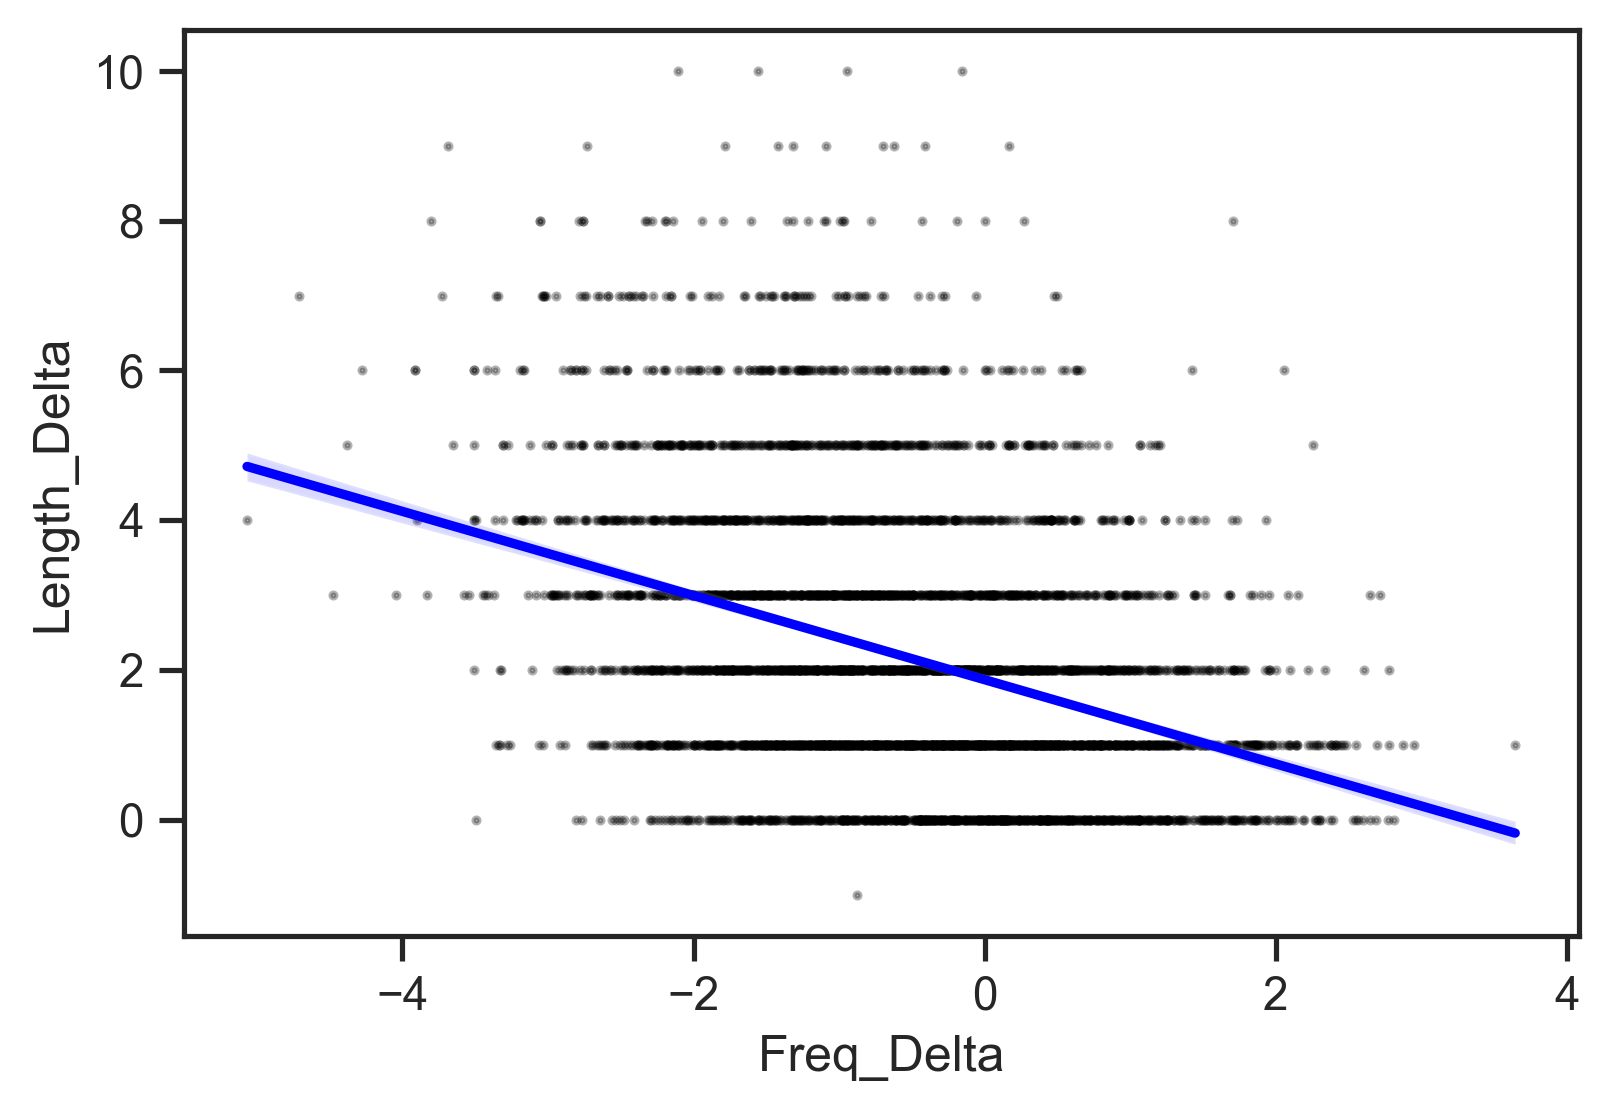

In [22]:
sns.regplot(x = final_df["Freq_Delta"], y = final_df["Length_Delta"],
            scatter_kws = {"color": "black", "alpha": 0.3,'s':2},
            line_kws = {"color": "blue"},
            ci = 95) 

<Axes: xlabel='Freq_Delta', ylabel='Length_Delta'>

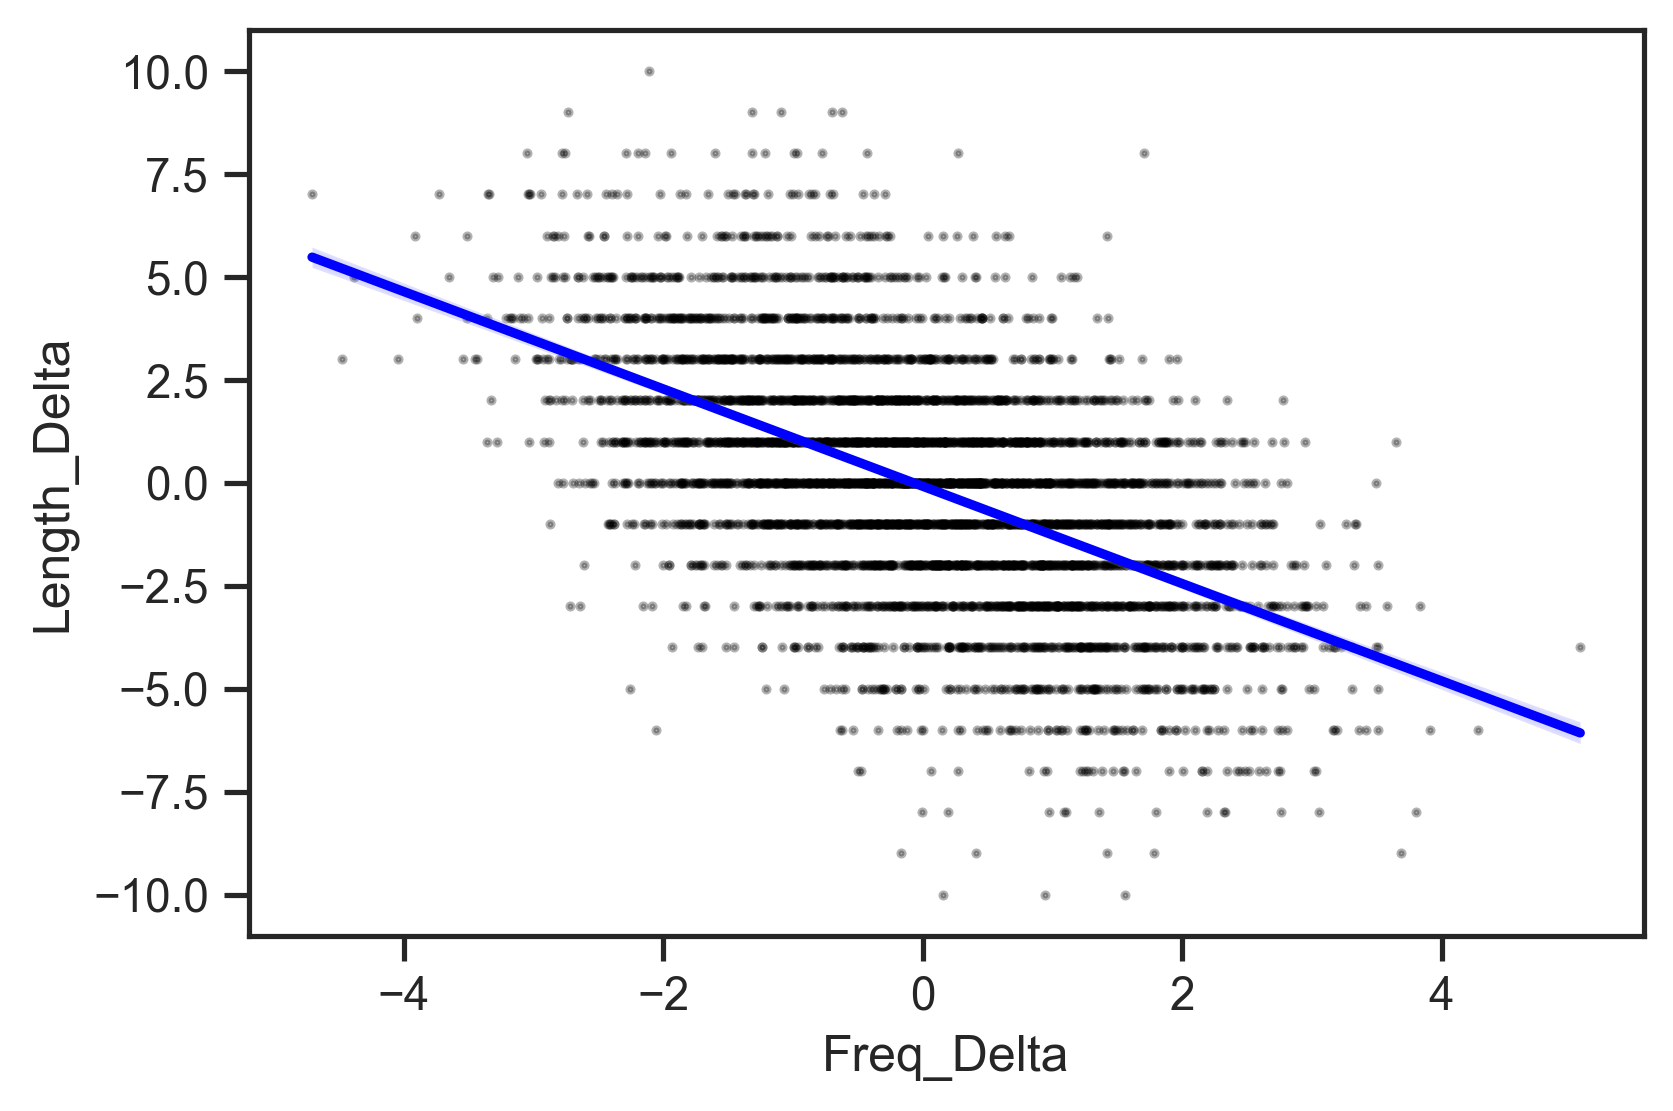

In [245]:
sns.regplot(x = final_df["Freq_Delta"], y = final_df["Length_Delta"],
            scatter_kws = {"color": "black", "alpha": 0.3,'s':2},
            line_kws = {"color": "blue"},
            ci = 95) 